In [1]:
import torch
import timm
import wandb
from tqdm.auto import tqdm
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, Normalize, CenterCrop
from torch.utils.data import DataLoader


RESIZED_SIZE = 256
TRAIN_ROOT = 'd:/Data/PTX/train'
VAL_ROOT = 'd:/Data/PTX/validation'
BATCH_SIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transforms = Compose([
    ToTensor(),
    Resize(size=(RESIZED_SIZE, RESIZED_SIZE), antialias=True),
    CenterCrop(size=(RESIZED_SIZE, RESIZED_SIZE))
])

train_dataset = ImageFolder(root=TRAIN_ROOT, transform=transforms)
val_dataset = ImageFolder(root=VAL_ROOT, transform=transforms)

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              )

val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False)


c:\Users\szabo\anaconda3\envs\lung_us\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


3

In [2]:
def train(model, train_dataloader, val_dataloader, loss_fn, optimizer, epochs=10, device='cpu', log_experiment=True):
    if log_experiment:
        val_loss_history = []
        val_acc_history = []
        artifact = wandb.Artifact('weights', type='model')
        
        run = wandb.init(
            project="PTX",
            config={
                "model": model_name,
                "epochs": epochs,
                "batch_size": BATCH_SIZE,
                "droupout": DROPOUT_RATE,
                "learning_rate": LEARNING_RATE,
                "training_image_size": RESIZED_SIZE
            })
    
    for epoch in tqdm(range(epochs)):
        print(f'Epoch {epoch+1}\n-------------------------------')
        train_loss, train_acc = train_epoch(model, train_dataloader, loss_fn, optimizer, device)
        print(f'train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}')
        val_loss, val_acc = test_epoch(model, val_dataloader, loss_fn, device)
        print(f'val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}')
        if log_experiment:
            val_loss_history.append(val_loss)
            val_acc_history.append(val_acc)

            if val_acc == max(val_acc_history) and val_loss == min(val_loss_history):
                torch.save(model.state_dict(), 'best.pt')            

            wandb.log({'train_loss': train_loss, 'train_acc': train_acc, 'val_loss': val_loss, 'val_acc': val_acc})
    
    
    torch.save(model.state_dict(), 'last.pt')

    if log_experiment:
        artifact.add_file('last.pt')
        artifact.add_file('best.pt')
        artifact.save()
        run.log_artifact(artifact)
        run.finish()


def train_epoch(model, dataloader, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model.train()
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    train_loss /= size
    correct /= size
    return train_loss, correct

def test_epoch(model, dataloader, loss_fn, device):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    return test_loss, correct

def crossvalidate_all_models(models, folds, dataset, loss_fn, lr, epochs=10, device='cpu', log_experiment=True):
    print(f'Starting k-fold cross validation for {epochs} epochs')
    total_size = len(dataset)
    split_size = total_size // folds

    for model in models:
        print(f'Cross validating {model.__class__.__name__}')
        for fold_nr in range(folds):            
            train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [total_size - split_size, split_size])

            train_dataloader = DataLoader(dataset=train_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

            val_dataloader = DataLoader(dataset=val_dataset,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)

            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            train(model=model.to(device),
                train_dataloader=train_dataloader,
                val_dataloader=val_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                epochs=epochs,
                device=device,
                log_experiment=log_experiment)

def train_all_models(models, train_dataset, val_dataloader, loss_fn, lr, epochs=10, device='cpu', log_experiment=True):
    print(f'Starting ensemble model training for {epochs} epochs')
    for model in models:
        print(f'Training {model.__class__.__name__}')
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        train(model=model.to(device),
              train_dataloader=train_dataloader,
              val_dataloader=val_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              epochs=epochs,
              device=device,
              log_experiment=log_experiment)

In [3]:
#Validates a model on val_dataloader, and displays the results
def validate(model, val_dataloader, device='cpu'):
    loss_fn = torch.nn.CrossEntropyLoss()
    loss, acc = test_epoch(model, val_dataloader, loss_fn, device)
    print(f'loss: {loss:.4f}, acc: {acc:.4f}')
    return loss, acc

In [4]:
model_names = ['resnet50', 'inception_v3', 'inception_resnet_v2', 'xception', 'vgg16']
n_classes = 3
DROPOUT_RATE = 0.5

timm_models = [timm.create_model(model_name,
                                 pretrained=True,
                                 num_classes=n_classes,
                                 drop_rate=DROPOUT_RATE) for model_name in model_names]

for model in timm_models:
    model.reset_classifier(3, 'max')

c:\Users\szabo\anaconda3\envs\lung_us\Lib\site-packages\timm\models\_factory.py:114: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [13]:
EPOCHS = 15
LEARNING_RATE = 1e-4
loss_fn = torch.nn.CrossEntropyLoss()
log = True

train_all_models(models=timm_models,
                 train_dataloader=train_dataloader,
                 val_dataloader=val_dataloader,
                 loss_fn=torch.nn.CrossEntropyLoss(),
                 lr=LEARNING_RATE,
                 epochs=EPOCHS,
                 device=DEVICE,
                 log_experiment=log)

Starting ensemble model training for 15 epochs
Training NoneType


AttributeError: 'NoneType' object has no attribute 'parameters'

In [6]:
EPOCHS = 15
LEARNING_RATE = 1e-4
loss_fn = torch.nn.CrossEntropyLoss()
model = feature_extractor_resnet.to(DEVICE)
log = False


train(model=model,
      train_dataloader=train_dataloader,
      val_dataloader=val_dataloader,
      loss_fn=loss_fn,
      optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
      epochs=EPOCHS,
      device=DEVICE,
      log_experiment=log)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1
-------------------------------
train_loss: 0.0237, train_acc: 0.7139


  7%|▋         | 1/15 [00:13<03:03, 13.13s/it]

val_loss: 0.0310, val_acc: 0.6389
Epoch 2
-------------------------------
train_loss: 0.0124, train_acc: 0.8617


 13%|█▎        | 2/15 [00:23<02:28, 11.46s/it]

val_loss: 0.0205, val_acc: 0.7500
Epoch 3
-------------------------------
train_loss: 0.0082, train_acc: 0.9066


 20%|██        | 3/15 [00:33<02:11, 10.92s/it]

val_loss: 0.0068, val_acc: 0.9306
Epoch 4
-------------------------------
train_loss: 0.0084, train_acc: 0.9031


 27%|██▋       | 4/15 [00:44<01:57, 10.68s/it]

val_loss: 0.0044, val_acc: 0.9583
Epoch 5
-------------------------------
train_loss: 0.0087, train_acc: 0.8995


 33%|███▎      | 5/15 [00:54<01:45, 10.53s/it]

val_loss: 0.0016, val_acc: 0.9722
Epoch 6
-------------------------------
train_loss: 0.0073, train_acc: 0.9137


 40%|████      | 6/15 [01:04<01:34, 10.49s/it]

val_loss: 0.0009, val_acc: 1.0000
Epoch 7
-------------------------------
train_loss: 0.0115, train_acc: 0.8972


 47%|████▋     | 7/15 [01:14<01:23, 10.42s/it]

val_loss: 0.0017, val_acc: 0.9722
Epoch 8
-------------------------------
train_loss: 0.0079, train_acc: 0.9137


 53%|█████▎    | 8/15 [01:25<01:12, 10.42s/it]

val_loss: 0.0014, val_acc: 0.9722
Epoch 9
-------------------------------
train_loss: 0.0072, train_acc: 0.9267


 60%|██████    | 9/15 [01:35<01:02, 10.40s/it]

val_loss: 0.0051, val_acc: 0.9444
Epoch 10
-------------------------------
train_loss: 0.0074, train_acc: 0.9255


 67%|██████▋   | 10/15 [01:46<00:52, 10.42s/it]

val_loss: 0.0014, val_acc: 0.9722
Epoch 11
-------------------------------
train_loss: 0.0060, train_acc: 0.9267


 73%|███████▎  | 11/15 [01:56<00:41, 10.49s/it]

val_loss: 0.0090, val_acc: 0.9167
Epoch 12
-------------------------------
train_loss: 0.0097, train_acc: 0.9102


 80%|████████  | 12/15 [02:07<00:31, 10.54s/it]

val_loss: 0.0015, val_acc: 0.9861
Epoch 13
-------------------------------
train_loss: 0.0117, train_acc: 0.9031


 87%|████████▋ | 13/15 [02:18<00:21, 10.55s/it]

val_loss: 0.0022, val_acc: 0.9722
Epoch 14
-------------------------------
train_loss: 0.0068, train_acc: 0.9267


 93%|█████████▎| 14/15 [02:28<00:10, 10.55s/it]

val_loss: 0.0041, val_acc: 0.9306
Epoch 15
-------------------------------
train_loss: 0.0061, train_acc: 0.9314


100%|██████████| 15/15 [02:39<00:00, 10.63s/it]

val_loss: 0.0018, val_acc: 0.9722


In [5]:
def gradcam_overlay(image, gradcam, colormap='jet', opacity=0.2):
    plt.imshow(image, cmap='gray')
    plt.imshow(gradcam, cmap=colormap, alpha=opacity)

In [6]:
model_names = ['resnet50', 'xception', 'inception_v3', 'inception_resnet_v2', 'vgg16']
model_weights = [f'weights/{model_name}.pt' for model_name in model_names]
model_target_layers = ['layer4.2.act3', 'act4', 'Mixed_7c.branch_pool.bn.act', 'conv2d_7b.bn.act', 'features.29']

models = [timm.create_model(model_name,
                            pretrained=True,
                            num_classes=3,
                            drop_rate=0.5) for model_name in model_names]

for i, model in enumerate(models):
    model.load_state_dict(torch.load(model_weights[i]))
    print(f'Loaded {model_names[i]} successfully')

Loaded resnet50 successfully
Loaded xception successfully
Loaded inception_v3 successfully
Loaded inception_resnet_v2 successfully
Loaded vgg16 successfully


In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from monai.visualize.class_activation_maps import GradCAM, GradCAMpp

n = 15
plt.figure(figsize=(15, 40))

test_model = feature_extractor_resnet
test_model.to('cpu')
gradcam = GradCAM(nn_module=test_model, target_layers='layer4.2.act3')

for param in test_model.parameters():
    param.requires_grad = True

test_model.eval()

for i in range(n):
    plt.subplot(n // 3 + 1, 3, i+1)
    image_number = np.random.randint(len(val_dataset))
    #image_number = i*20
    test_image = val_dataset[image_number][0].unsqueeze(0)
    test_label = val_dataset[image_number][1]

    pred = test_model(test_image).softmax(1).argmax(1).item()
    gradcam_result = 1-gradcam(test_image)

    gradcam_overlay(test_image.squeeze(0).permute(1, 2, 0).to('cpu'), gradcam_result[0].squeeze(0).cpu().numpy(), opacity=0.25)
    plt.title(f'ID: {image_number} | True: {test_label} | Pred: {pred}')
    plt.axis('off')

In [114]:
test_batch = next(iter(val_dataloader))
test_preds = models[1](test_batch[0]).softmax(1).argmax(1)
test_labels = test_batch[1]

In [115]:
test_preds

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1])

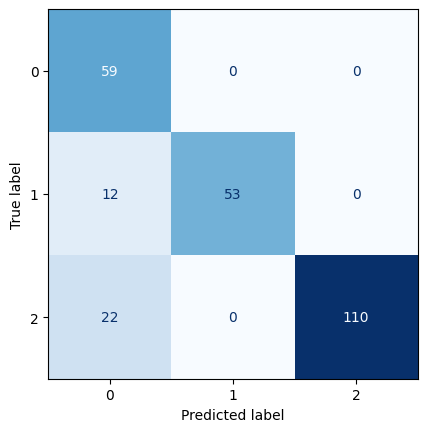

In [88]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
labels = [0,1,2]
classes = ('barcode', 'lung pulse', 'seashore')

confmat = confusion_matrix(test_labels, test_preds, labels=labels)
ConfusionMatrixDisplay(confmat, display_labels=labels).plot(cmap='Blues', colorbar=False)


In [108]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import numpy as np
from matplotlib import pyplot as plt

def display_confusion_matrix(true_labels, predicted_labels, class_labels):
    cf_matrix = confusion_matrix(test_labels, test_preds)
    
    if cf_matrix.shape[0] < len(class_labels):
        cf_matrix = np.pad(cf_matrix, (0, len(class_labels) - cf_matrix.shape[0]), 'constant')
    
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None],
                         index = [i for i in class_labels],
                         columns = [i for i in class_labels])
    plt.figure(figsize = (7,7))
    sn.heatmap(df_cm, annot=True, cmap='Blues', cbar=False)
    #plt.savefig('output.png')

In [1]:
from general import get_metrics_from_confusion_matrix
import torch

y = torch.tensor([1,1,1,1])
pred_y = torch.tensor([1,1,1,1])

test = get_metrics_from_confusion_matrix(y, pred_y, 3)
test

c:\Users\szabo\anaconda3\envs\lung_us\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Repos\PTX_ensemble_classifier\general.py:85: RuntimeWarning: invalid value encountered in scalar divide
  sensitivity_per_class[class_id] = padded_cf_matrix[class_id, class_id] / np.sum(padded_cf_matrix[class_id, :])
d:\Repos\PTX_ensemble_classifier\general.py:86: RuntimeWarning: invalid value encountered in scalar divide
  specificity_per_class[class_id] = padded_cf_matrix[class_id, class_id] / np.sum(padded_cf_matrix[:, class_id])


(array([ 1., nan, nan]), array([ 1., nan, nan]))

In [15]:
import numpy as np
mat = np.array([[1, 2, 3],
                [1,2,3],
                [np.nan,np.nan,np.nan]])


mat

array([[ 1.,  2.,  3.],
       [ 1.,  2.,  3.],
       [nan, nan, nan]])

In [33]:
train_dataset[0][0].max()

tensor(1.6261)